In [1]:
import csv
import cv2
import itertools
import numpy as np
import pandas as pd
import os
import sys
import tempfile
import tqdm

from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


import tensorflow_addons as tfa

In [2]:
pose_sample_rpi_path = os.path.join(os.getcwd(), 'examples/lite/examples/pose_estimation/raspberry_pi')
sys.path.append(pose_sample_rpi_path)

# Load MoveNet Thunder model
import utils
from data import BodyPart
from ml import Movenet
movenet = Movenet('movenet_thunder')

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [3]:
data_path = '/home/shellygoel2324/data_merged.csv'
#labels_path = '/home/shellygoel2324/processedLabels.csv'

In [4]:
def load_pose_landmarks(csv_path):
    """Loads a CSV created by MoveNetPreprocessor.
    Returns:
        X: Detected landmark coordinates and scores of shape (N, 17 * 3)
        y: Ground truth labels of shape (N, label_count)
        classes: The list of all class names found in the dataset
        dataframe: The CSV loaded as a Pandas dataframe features (X) and ground
        truth labels (y) to use later to train a pose classification model.
    """

    # Load the CSV file
    dataframe = pd.read_csv(csv_path)
    
    dataframe["label"] = dataframe["label"] - 1
  
    print(dataframe["label"].unique())
    
    
    curr_num = dataframe.loc[dataframe['label'] == 0]
    
    dataFinal = curr_num.sample(n=5000)
    #print(f"{i}:{curr_num_sub.shape}")
    #dataFinal.append(curr_num_sub)
    
    print(f"{0}:{dataFinal.shape}")
    
    '''
    0: 5000
    1:2500*2
        2: 1000*5
            3:250*20
                4: 250*20
                    5: 50*100
                
    '''
        
    for i in range(1, 6):
        
        curr_num = dataframe.loc[dataframe['label'] == i]
        
        '''
        num_s = 0
        if i == 1:
            num_s = 2
        if i == 2:
            num_s = 5
        if i == 3:
            num_s = 20
        if i == 4:
            num_s = 20     
        if i == 5:
            num_s = 100
            '''
        
        if i in [1,2,3,4]:
            sample_n = 7500
        else:
            sample_n = 5000
        
        curr_num_sub = curr_num.sample(n=sample_n, replace = True)
        print(f"{i}:{curr_num_sub.shape}")
        dataFinal = dataFinal.append(curr_num_sub, ignore_index=True)
        
    
    
    print(dataFinal.shape)
    
    dataframe = dataFinal
    labels = dataframe["label"]#pd.read_csv(labels_path, header=None)
    
    print(labels.unique())
    df_to_process = dataframe.copy()

    # Drop the file_name columns as you don't need it during training.
    df_to_process.drop(columns=['file_name'], inplace=True)

    # Extract the list of class names
    df_to_process.pop('class_name')
    df_to_process.pop('class_no')
    df_to_process.pop('label')

    # Extract the labels
    y = labels
    classes = range(6)

    # Convert the input features and labels into the correct format for training.
    X = df_to_process.astype('float64')
    y = keras.utils.to_categorical(y)

    return X, y, classes, dataframe

In [5]:
# Load the train data
X, y, class_names, _ = load_pose_landmarks(data_path)

print(X.shape, y.shape)

# Split training data (X, y) into (X_train, y_train) and (X_val, y_val)

# 80/10/10
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=1) # 0.25 x 0.8 = 0.2

#print(X_train.shape, X_val.shape, X_test.shape)

#60/20/20
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
#X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2

[0. 3. 1. 2. 4. 5.]
0:(5000, 55)
1:(7500, 55)
2:(7500, 55)
3:(7500, 55)
4:(7500, 55)
5:(5000, 55)
(40000, 55)
[0. 1. 2. 3. 4. 5.]
(40000, 51) (40000, 6)


In [6]:
print("TRAIN DISTRIBUTION")

sample_dist = []
for i in range(0,6):
    
    num_i = 0
    for sample in y_train:
            if tf.argmax(sample) == i:
                num_i+=1
    dist = num_i/len(y_train)
    print(f"{i}: {dist}")
    print(f"{i}: {num_i}")
    sample_dist.append(dist)


print("\nTEST DISTRIBUTION")
for i in range(0,6):
    
    num_i = 0
    for sample in y_test:
            if tf.argmax(sample) == i:
                num_i+=1

    dist = num_i/len(y_test)
    print(f"{i}: {dist}")
    #sample_dist.append(dist)

TRAIN DISTRIBUTION


2022-05-31 04:39:23.722913: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-05-31 04:39:23.722979: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (cs229-vm-vm): /proc/driver/nvidia/version does not exist
2022-05-31 04:39:23.727126: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


0: 0.125125
0: 4004
1: 0.18603125
1: 5953
2: 0.1878125
2: 6010
3: 0.18796875
3: 6015
4: 0.18878125
4: 6041
5: 0.12428125
5: 3977

TEST DISTRIBUTION
0: 0.1165
1: 0.20125
2: 0.19125
3: 0.17975
4: 0.19025
5: 0.121


In [7]:
sample_dist = sample_dist/np.linalg.norm(sample_dist)
weight_balanced= [1/s for s in sample_dist]

print(sample_dist)
print(weight_balanced)
#weight_balanced = weight_balanced/np.linalg.norm(weight_balanced)
#print(weight_balanced)
#print(np.sum(weight_balanced))

[0.30174363 0.44862134 0.45291689 0.4532937  0.45525307 0.2997089 ]
[3.314071570768693, 2.2290513303137653, 2.207910577264201, 2.2060752401259927, 2.196580461737766, 3.3365709251591262]


In [8]:
class_weights = {}
for i in range(6):
    class_weights[i] = weight_balanced[i]

In [9]:
def get_center_point(landmarks, left_bodypart, right_bodypart):
    """Calculates the center point of the two given landmarks."""
    
    left = tf.gather(landmarks, left_bodypart.value, axis=1)
    right = tf.gather(landmarks, right_bodypart.value, axis=1)
    center = left * 0.5 + right * 0.5
    return center


def get_pose_size(landmarks, torso_size_multiplier=2.5):
    """Calculates pose size.

        It is the maximum of two values:
        * Torso size multiplied by `torso_size_multiplier`
        * Maximum distance from pose center to any pose landmark
    """
    # Hips center
    hips_center = get_center_point(landmarks, BodyPart.LEFT_HIP, 
                                 BodyPart.RIGHT_HIP)

    # Shoulders center
    shoulders_center = get_center_point(landmarks, BodyPart.LEFT_SHOULDER,
                                      BodyPart.RIGHT_SHOULDER)

    # Torso size as the minimum body size
    torso_size = tf.linalg.norm(shoulders_center - hips_center)

    # Pose center
    pose_center_new = get_center_point(landmarks, BodyPart.LEFT_HIP, 
                                     BodyPart.RIGHT_HIP)
    pose_center_new = tf.expand_dims(pose_center_new, axis=1)
    # Broadcast the pose center to the same size as the landmark vector to
    # perform substraction
    pose_center_new = tf.broadcast_to(pose_center_new,
                                    [tf.size(landmarks) // (17*2), 17, 2])

    # Dist to pose center
    d = tf.gather(landmarks - pose_center_new, 0, axis=0,
                name="dist_to_pose_center")
    # Max dist to pose center
    max_dist = tf.reduce_max(tf.linalg.norm(d, axis=0))

    # Normalize scale
    pose_size = tf.maximum(torso_size * torso_size_multiplier, max_dist)

    return pose_size


def normalize_pose_landmarks(landmarks):
    """Normalizes the landmarks translation by moving the pose center to (0,0) and
        scaling it to a constant pose size.
    """
    # Move landmarks so that the pose center becomes (0,0)
    pose_center = get_center_point(landmarks, BodyPart.LEFT_HIP, 
                                 BodyPart.RIGHT_HIP)
    pose_center = tf.expand_dims(pose_center, axis=1)
    # Broadcast the pose center to the same size as the landmark vector to perform
    # substraction
    pose_center = tf.broadcast_to(pose_center, 
                                [tf.size(landmarks) // (17*2), 17, 2])
    landmarks = landmarks - pose_center

    # Scale the landmarks to a constant pose size
    pose_size = get_pose_size(landmarks)
    landmarks /= pose_size

    return landmarks


def landmarks_to_embedding(landmarks_and_scores):
    """Converts the input landmarks into a pose embedding."""
    # Reshape the flat input into a matrix with shape=(17, 3)
    reshaped_inputs = keras.layers.Reshape((17, 3))(landmarks_and_scores)

    # Normalize landmarks 2D
    landmarks = normalize_pose_landmarks(reshaped_inputs[:, :, :2])

    # Flatten the normalized landmark coordinates into a vector
    embedding = keras.layers.Flatten()(landmarks)

    return embedding

def no_normalization(landmarks_and_scores):
    """Converts the input landmarks into a pose embedding."""
    # Reshape the flat input into a matrix with shape=(17, 3)
    landmarks = keras.layers.Reshape((17, 3))(landmarks_and_scores)

    # Flatten the landmark coordinates into a vector
    embedding = keras.layers.Flatten()(landmarks[:, :, :2])

    return embedding

In [10]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """Plots the confusion matrix."""
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=55)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
              horizontalalignment="center",
              color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


## Normalize everything

In [11]:
# Define the model
inputs = tf.keras.Input(shape=(51))
embedding = landmarks_to_embedding(inputs)

layer = keras.layers.Dense(128, activation=tf.nn.relu6)(embedding)
layer = keras.layers.Dropout(0.5)(layer)
layer = keras.layers.Dense(64, activation=tf.nn.relu6)(layer)
layer = keras.layers.Dropout(0.5)(layer)
outputs = keras.layers.Dense(len(class_names), activation="softmax")(layer)

model = keras.Model(inputs, outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 51)]         0           []                               
                                                                                                  
 reshape (Reshape)              (None, 17, 3)        0           ['input_1[0][0]']                
                                                                                                  
 tf.__operators__.getitem (Slic  (None, 17, 2)       0           ['reshape[0][0]']                
 ingOpLambda)                                                                                     
                                                                                                  
 tf.compat.v1.gather (TFOpLambd  (None, 2)           0           ['tf.__operators__.getitem[0]

 )                                                                                                
                                                                                                  
 tf.broadcast_to_1 (TFOpLambda)  (None, 17, 2)       0           ['tf.expand_dims_1[0][0]',       
                                                                  'tf.compat.v1.floor_div_1[0][0]'
                                                                 ]                                
                                                                                                  
 tf.__operators__.add_2 (TFOpLa  (None, 2)           0           ['tf.math.multiply_4[0][0]',     
 mbda)                                                            'tf.math.multiply_5[0][0]']     
                                                                                                  
 tf.__operators__.add_1 (TFOpLa  (None, 2)           0           ['tf.math.multiply_2[0][0]',     
 mbda)    

In [12]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

In [13]:
model.compile(
    optimizer='adam',
    loss=tfa.losses.SigmoidFocalCrossEntropy(),#'categorical_crossentropy',
    metrics=METRICS
)

# Add a checkpoint callback to store the checkpoint that has the highest
# validation accuracy.
#checkpoint_path = "weights.best.hdf5"

checkpoint_path = "weights.best.onlyfocalloss"
checkpoint = keras.callbacks.ModelCheckpoint(checkpoint_path,
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True,
                             mode='min')
earlystopping = keras.callbacks.EarlyStopping(monitor='val_loss', 
                                              patience=20)

# Start training
history = model.fit(X_train, y_train,
                    epochs=200,
                    batch_size=16,
                    validation_data=(X_val, y_val),
                    callbacks=[checkpoint, earlystopping])

Epoch 1/200
1998/2000 [============================>.] - ETA: 0s - loss: 0.1803 - tp: 6783.0000 - fp: 1104.0000 - tn: 158736.0000 - fn: 25185.0000 - accuracy: 0.8629 - precision: 0.8600 - recall: 0.2122 - auc: 0.9041 - prc: 0.6763
Epoch 1: val_loss improved from inf to 0.12109, saving model to weights.best.onlyfocalloss


2022-05-31 04:40:27.062751: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: weights.best.onlyfocalloss/assets
2000/2000 [==============================] - 19s 7ms/step - loss: 0.1803 - tp: 6794.0000 - fp: 1106.0000 - tn: 158894.0000 - fn: 25206.0000 - accuracy: 0.8630 - precision: 0.8600 - recall: 0.2123 - auc: 0.9041 - prc: 0.6763 - val_loss: 0.1211 - val_tp: 1623.0000 - val_fp: 131.0000 - val_tn: 19869.0000 - val_fn: 2377.0000 - val_accuracy: 0.8955 - val_precision: 0.9253 - val_recall: 0.4058 - val_auc: 0.9590 - val_prc: 0.8404
Epoch 2/200
1996/2000 [============================>.] - ETA: 0s - loss: 0.1318 - tp: 13087.0000 - fp: 1624.0000 - tn: 158056.0000 - fn: 18849.0000 - accuracy: 0.8932 - precision: 0.8896 - recall: 0.4098 - auc: 0.9500 - prc: 0.8061
Epoch 2: val_loss improved from 0.12109 to 0.10200, saving model to weights.best.onlyfocalloss
INFO:tensorflow:Assets written to: weights.best.onlyfocalloss/assets
2000/2000 [==============================] - 12s 6ms/step - loss: 0.1318 - tp: 13112.0000 - fp: 1629.0000 - 

2000/2000 [==============================] - 12s 6ms/step - loss: 0.0985 - tp: 19510.0000 - fp: 1820.0000 - tn: 158180.0000 - fn: 12490.0000 - accuracy: 0.9255 - precision: 0.9147 - recall: 0.6097 - auc: 0.9730 - prc: 0.8906 - val_loss: 0.0780 - val_tp: 2680.0000 - val_fp: 176.0000 - val_tn: 19824.0000 - val_fn: 1320.0000 - val_accuracy: 0.9377 - val_precision: 0.9384 - val_recall: 0.6700 - val_auc: 0.9834 - val_prc: 0.9311
Epoch 12/200
1990/2000 [============================>.] - ETA: 0s - loss: 0.0983 - tp: 19477.0000 - fp: 1772.0000 - tn: 157428.0000 - fn: 12363.0000 - accuracy: 0.9260 - precision: 0.9166 - recall: 0.6117 - auc: 0.9732 - prc: 0.8912
Epoch 12: val_loss improved from 0.07804 to 0.07680, saving model to weights.best.onlyfocalloss
INFO:tensorflow:Assets written to: weights.best.onlyfocalloss/assets
2000/2000 [==============================] - 12s 6ms/step - loss: 0.0982 - tp: 19578.0000 - fp: 1781.0000 - tn: 158219.0000 - fn: 12422.0000 - accuracy: 0.9260 - precision: 0

Epoch 22/200
1996/2000 [============================>.] - ETA: 0s - loss: 0.0910 - tp: 20738.0000 - fp: 1723.0000 - tn: 157957.0000 - fn: 11198.0000 - accuracy: 0.9326 - precision: 0.9233 - recall: 0.6494 - auc: 0.9771 - prc: 0.9078
Epoch 22: val_loss did not improve from 0.06840
2000/2000 [==============================] - 10s 5ms/step - loss: 0.0910 - tp: 20779.0000 - fp: 1729.0000 - tn: 158271.0000 - fn: 11221.0000 - accuracy: 0.9326 - precision: 0.9232 - recall: 0.6493 - auc: 0.9771 - prc: 0.9078 - val_loss: 0.0689 - val_tp: 2918.0000 - val_fp: 183.0000 - val_tn: 19817.0000 - val_fn: 1082.0000 - val_accuracy: 0.9473 - val_precision: 0.9410 - val_recall: 0.7295 - val_auc: 0.9873 - val_prc: 0.9462
Epoch 23/200
1993/2000 [============================>.] - ETA: 0s - loss: 0.0901 - tp: 20837.0000 - fp: 1741.0000 - tn: 157699.0000 - fn: 11051.0000 - accuracy: 0.9331 - precision: 0.9229 - recall: 0.6534 - auc: 0.9777 - prc: 0.9091
Epoch 23: val_loss did not improve from 0.06840
2000/2000 

Epoch 33/200
1994/2000 [============================>.] - ETA: 0s - loss: 0.0877 - tp: 21217.0000 - fp: 1686.0000 - tn: 157834.0000 - fn: 10687.0000 - accuracy: 0.9354 - precision: 0.9264 - recall: 0.6650 - auc: 0.9790 - prc: 0.9141
Epoch 33: val_loss did not improve from 0.06204
2000/2000 [==============================] - 9s 5ms/step - loss: 0.0877 - tp: 21283.0000 - fp: 1693.0000 - tn: 158307.0000 - fn: 10717.0000 - accuracy: 0.9354 - precision: 0.9263 - recall: 0.6651 - auc: 0.9790 - prc: 0.9141 - val_loss: 0.0649 - val_tp: 2853.0000 - val_fp: 147.0000 - val_tn: 19853.0000 - val_fn: 1147.0000 - val_accuracy: 0.9461 - val_precision: 0.9510 - val_recall: 0.7132 - val_auc: 0.9889 - val_prc: 0.9526
Epoch 34/200
1989/2000 [============================>.] - ETA: 0s - loss: 0.0871 - tp: 21196.0000 - fp: 1642.0000 - tn: 157478.0000 - fn: 10628.0000 - accuracy: 0.9357 - precision: 0.9281 - recall: 0.6660 - auc: 0.9794 - prc: 0.9155
Epoch 34: val_loss did not improve from 0.06204
2000/2000 [

Epoch 45/200
1991/2000 [============================>.] - ETA: 0s - loss: 0.0830 - tp: 21963.0000 - fp: 1677.0000 - tn: 157603.0000 - fn: 9893.0000 - accuracy: 0.9395 - precision: 0.9291 - recall: 0.6894 - auc: 0.9814 - prc: 0.9239
Epoch 45: val_loss did not improve from 0.06080
2000/2000 [==============================] - 9s 4ms/step - loss: 0.0830 - tp: 22062.0000 - fp: 1683.0000 - tn: 158317.0000 - fn: 9938.0000 - accuracy: 0.9395 - precision: 0.9291 - recall: 0.6894 - auc: 0.9814 - prc: 0.9240 - val_loss: 0.0638 - val_tp: 2893.0000 - val_fp: 123.0000 - val_tn: 19877.0000 - val_fn: 1107.0000 - val_accuracy: 0.9487 - val_precision: 0.9592 - val_recall: 0.7232 - val_auc: 0.9896 - val_prc: 0.9557
Epoch 46/200
2000/2000 [==============================] - ETA: 0s - loss: 0.0826 - tp: 22168.0000 - fp: 1603.0000 - tn: 158397.0000 - fn: 9832.0000 - accuracy: 0.9404 - precision: 0.9326 - recall: 0.6927 - auc: 0.9815 - prc: 0.9247
Epoch 46: val_loss did not improve from 0.06080
2000/2000 [===

1988/2000 [============================>.] - ETA: 0s - loss: 0.0814 - tp: 22208.0000 - fp: 1641.0000 - tn: 157399.0000 - fn: 9600.0000 - accuracy: 0.9411 - precision: 0.9312 - recall: 0.6982 - auc: 0.9821 - prc: 0.9270
Epoch 56: val_loss did not improve from 0.05727
2000/2000 [==============================] - 9s 4ms/step - loss: 0.0814 - tp: 22349.0000 - fp: 1648.0000 - tn: 158352.0000 - fn: 9651.0000 - accuracy: 0.9412 - precision: 0.9313 - recall: 0.6984 - auc: 0.9822 - prc: 0.9271 - val_loss: 0.0573 - val_tp: 3034.0000 - val_fp: 129.0000 - val_tn: 19871.0000 - val_fn: 966.0000 - val_accuracy: 0.9544 - val_precision: 0.9592 - val_recall: 0.7585 - val_auc: 0.9913 - val_prc: 0.9624
Epoch 57/200
1998/2000 [============================>.] - ETA: 0s - loss: 0.0809 - tp: 22190.0000 - fp: 1639.0000 - tn: 158201.0000 - fn: 9778.0000 - accuracy: 0.9405 - precision: 0.9312 - recall: 0.6941 - auc: 0.9823 - prc: 0.9277
Epoch 57: val_loss did not improve from 0.05727
2000/2000 [=================

1997/2000 [============================>.] - ETA: 0s - loss: 0.0803 - tp: 22344.0000 - fp: 1589.0000 - tn: 158171.0000 - fn: 9608.0000 - accuracy: 0.9416 - precision: 0.9336 - recall: 0.6993 - auc: 0.9827 - prc: 0.9292
Epoch 67: val_loss did not improve from 0.05533
2000/2000 [==============================] - 10s 5ms/step - loss: 0.0803 - tp: 22376.0000 - fp: 1590.0000 - tn: 158410.0000 - fn: 9624.0000 - accuracy: 0.9416 - precision: 0.9337 - recall: 0.6992 - auc: 0.9827 - prc: 0.9292 - val_loss: 0.0565 - val_tp: 3033.0000 - val_fp: 137.0000 - val_tn: 19863.0000 - val_fn: 967.0000 - val_accuracy: 0.9540 - val_precision: 0.9568 - val_recall: 0.7582 - val_auc: 0.9918 - val_prc: 0.9639
Epoch 68/200
1991/2000 [============================>.] - ETA: 0s - loss: 0.0790 - tp: 22433.0000 - fp: 1578.0000 - tn: 157702.0000 - fn: 9423.0000 - accuracy: 0.9424 - precision: 0.9343 - recall: 0.7042 - auc: 0.9831 - prc: 0.9313
Epoch 68: val_loss did not improve from 0.05533
2000/2000 [================

Epoch 78/200
1988/2000 [============================>.] - ETA: 0s - loss: 0.0774 - tp: 22603.0000 - fp: 1588.0000 - tn: 157452.0000 - fn: 9205.0000 - accuracy: 0.9434 - precision: 0.9344 - recall: 0.7106 - auc: 0.9839 - prc: 0.9338
Epoch 78: val_loss did not improve from 0.05391
2000/2000 [==============================] - 9s 5ms/step - loss: 0.0774 - tp: 22743.0000 - fp: 1597.0000 - tn: 158403.0000 - fn: 9257.0000 - accuracy: 0.9435 - precision: 0.9344 - recall: 0.7107 - auc: 0.9839 - prc: 0.9339 - val_loss: 0.0548 - val_tp: 3092.0000 - val_fp: 128.0000 - val_tn: 19872.0000 - val_fn: 908.0000 - val_accuracy: 0.9568 - val_precision: 0.9602 - val_recall: 0.7730 - val_auc: 0.9923 - val_prc: 0.9664
Epoch 79/200
1989/2000 [============================>.] - ETA: 0s - loss: 0.0783 - tp: 22514.0000 - fp: 1573.0000 - tn: 157547.0000 - fn: 9310.0000 - accuracy: 0.9430 - precision: 0.9347 - recall: 0.7075 - auc: 0.9836 - prc: 0.9325
Epoch 79: val_loss improved from 0.05391 to 0.05337, saving mod

2000/2000 [==============================] - ETA: 0s - loss: 0.0764 - tp: 23103.0000 - fp: 1542.0000 - tn: 158458.0000 - fn: 8897.0000 - accuracy: 0.9456 - precision: 0.9374 - recall: 0.7220 - auc: 0.9844 - prc: 0.9362
Epoch 89: val_loss did not improve from 0.05315
2000/2000 [==============================] - 9s 4ms/step - loss: 0.0764 - tp: 23103.0000 - fp: 1542.0000 - tn: 158458.0000 - fn: 8897.0000 - accuracy: 0.9456 - precision: 0.9374 - recall: 0.7220 - auc: 0.9844 - prc: 0.9362 - val_loss: 0.0549 - val_tp: 3091.0000 - val_fp: 141.0000 - val_tn: 19859.0000 - val_fn: 909.0000 - val_accuracy: 0.9563 - val_precision: 0.9564 - val_recall: 0.7728 - val_auc: 0.9922 - val_prc: 0.9657
Epoch 90/200
1999/2000 [============================>.] - ETA: 0s - loss: 0.0771 - tp: 22856.0000 - fp: 1558.0000 - tn: 158362.0000 - fn: 9128.0000 - accuracy: 0.9443 - precision: 0.9362 - recall: 0.7146 - auc: 0.9841 - prc: 0.9348
Epoch 90: val_loss improved from 0.05315 to 0.05275, saving model to weights

1995/2000 [============================>.] - ETA: 0s - loss: 0.0766 - tp: 23147.0000 - fp: 1627.0000 - tn: 157973.0000 - fn: 8773.0000 - accuracy: 0.9457 - precision: 0.9343 - recall: 0.7252 - auc: 0.9845 - prc: 0.9365
Epoch 100: val_loss did not improve from 0.05260
2000/2000 [==============================] - 9s 5ms/step - loss: 0.0766 - tp: 23199.0000 - fp: 1630.0000 - tn: 158370.0000 - fn: 8801.0000 - accuracy: 0.9457 - precision: 0.9344 - recall: 0.7250 - auc: 0.9845 - prc: 0.9365 - val_loss: 0.0543 - val_tp: 3053.0000 - val_fp: 111.0000 - val_tn: 19889.0000 - val_fn: 947.0000 - val_accuracy: 0.9559 - val_precision: 0.9649 - val_recall: 0.7632 - val_auc: 0.9925 - val_prc: 0.9674
Epoch 101/200
1990/2000 [============================>.] - ETA: 0s - loss: 0.0766 - tp: 22896.0000 - fp: 1639.0000 - tn: 157561.0000 - fn: 8944.0000 - accuracy: 0.9446 - precision: 0.9332 - recall: 0.7191 - auc: 0.9844 - prc: 0.9350
Epoch 101: val_loss improved from 0.05260 to 0.05203, saving model to weig

Epoch 111/200
1988/2000 [============================>.] - ETA: 0s - loss: 0.0746 - tp: 23206.0000 - fp: 1539.0000 - tn: 157501.0000 - fn: 8602.0000 - accuracy: 0.9469 - precision: 0.9378 - recall: 0.7296 - auc: 0.9852 - prc: 0.9387
Epoch 111: val_loss did not improve from 0.05039
2000/2000 [==============================] - 7s 4ms/step - loss: 0.0745 - tp: 23350.0000 - fp: 1543.0000 - tn: 158457.0000 - fn: 8650.0000 - accuracy: 0.9469 - precision: 0.9380 - recall: 0.7297 - auc: 0.9852 - prc: 0.9389 - val_loss: 0.0505 - val_tp: 3204.0000 - val_fp: 121.0000 - val_tn: 19879.0000 - val_fn: 796.0000 - val_accuracy: 0.9618 - val_precision: 0.9636 - val_recall: 0.8010 - val_auc: 0.9935 - val_prc: 0.9714
Epoch 112/200
1996/2000 [============================>.] - ETA: 0s - loss: 0.0742 - tp: 23431.0000 - fp: 1592.0000 - tn: 158088.0000 - fn: 8505.0000 - accuracy: 0.9473 - precision: 0.9364 - recall: 0.7337 - auc: 0.9853 - prc: 0.9396
Epoch 112: val_loss did not improve from 0.05039
2000/2000 [

Epoch 123/200
1980/2000 [============================>.] - ETA: 0s - loss: 0.0740 - tp: 23173.0000 - fp: 1560.0000 - tn: 156840.0000 - fn: 8507.0000 - accuracy: 0.9470 - precision: 0.9369 - recall: 0.7315 - auc: 0.9855 - prc: 0.9398
Epoch 123: val_loss did not improve from 0.04910
2000/2000 [==============================] - 5s 3ms/step - loss: 0.0740 - tp: 23401.0000 - fp: 1575.0000 - tn: 158425.0000 - fn: 8599.0000 - accuracy: 0.9470 - precision: 0.9369 - recall: 0.7313 - auc: 0.9855 - prc: 0.9398 - val_loss: 0.0507 - val_tp: 3185.0000 - val_fp: 130.0000 - val_tn: 19870.0000 - val_fn: 815.0000 - val_accuracy: 0.9606 - val_precision: 0.9608 - val_recall: 0.7962 - val_auc: 0.9934 - val_prc: 0.9712
Epoch 124/200
1999/2000 [============================>.] - ETA: 0s - loss: 0.0741 - tp: 23402.0000 - fp: 1567.0000 - tn: 158353.0000 - fn: 8582.0000 - accuracy: 0.9471 - precision: 0.9372 - recall: 0.7317 - auc: 0.9854 - prc: 0.9399
Epoch 124: val_loss did not improve from 0.04910
2000/2000 [

INFO:tensorflow:Assets written to: weights.best.onlyfocalloss/assets
2000/2000 [==============================] - 8s 4ms/step - loss: 0.0722 - tp: 23781.0000 - fp: 1521.0000 - tn: 158479.0000 - fn: 8219.0000 - accuracy: 0.9493 - precision: 0.9399 - recall: 0.7432 - auc: 0.9861 - prc: 0.9427 - val_loss: 0.0486 - val_tp: 3230.0000 - val_fp: 117.0000 - val_tn: 19883.0000 - val_fn: 770.0000 - val_accuracy: 0.9630 - val_precision: 0.9650 - val_recall: 0.8075 - val_auc: 0.9940 - val_prc: 0.9735
Epoch 135/200
1995/2000 [============================>.] - ETA: 0s - loss: 0.0742 - tp: 23569.0000 - fp: 1585.0000 - tn: 158015.0000 - fn: 8351.0000 - accuracy: 0.9481 - precision: 0.9370 - recall: 0.7384 - auc: 0.9855 - prc: 0.9403
Epoch 135: val_loss did not improve from 0.04861
2000/2000 [==============================] - 5s 3ms/step - loss: 0.0743 - tp: 23625.0000 - fp: 1591.0000 - tn: 158409.0000 - fn: 8375.0000 - accuracy: 0.9481 - precision: 0.9369 - recall: 0.7383 - auc: 0.9854 - prc: 0.9402 -

Epoch 146/200
1988/2000 [============================>.] - ETA: 0s - loss: 0.0725 - tp: 23581.0000 - fp: 1508.0000 - tn: 157532.0000 - fn: 8227.0000 - accuracy: 0.9490 - precision: 0.9399 - recall: 0.7414 - auc: 0.9861 - prc: 0.9429
Epoch 146: val_loss did not improve from 0.04803
2000/2000 [==============================] - 5s 3ms/step - loss: 0.0725 - tp: 23713.0000 - fp: 1517.0000 - tn: 158483.0000 - fn: 8287.0000 - accuracy: 0.9489 - precision: 0.9399 - recall: 0.7410 - auc: 0.9861 - prc: 0.9428 - val_loss: 0.0507 - val_tp: 3171.0000 - val_fp: 114.0000 - val_tn: 19886.0000 - val_fn: 829.0000 - val_accuracy: 0.9607 - val_precision: 0.9653 - val_recall: 0.7928 - val_auc: 0.9936 - val_prc: 0.9720
Epoch 147/200
1987/2000 [============================>.] - ETA: 0s - loss: 0.0714 - tp: 23725.0000 - fp: 1543.0000 - tn: 157417.0000 - fn: 8067.0000 - accuracy: 0.9496 - precision: 0.9389 - recall: 0.7463 - auc: 0.9865 - prc: 0.9442
Epoch 147: val_loss improved from 0.04803 to 0.04769, saving

1979/2000 [============================>.] - ETA: 0s - loss: 0.0726 - tp: 23447.0000 - fp: 1466.0000 - tn: 156854.0000 - fn: 8217.0000 - accuracy: 0.9490 - precision: 0.9412 - recall: 0.7405 - auc: 0.9861 - prc: 0.9427
Epoch 157: val_loss did not improve from 0.04729
2000/2000 [==============================] - 5s 3ms/step - loss: 0.0727 - tp: 23680.0000 - fp: 1482.0000 - tn: 158518.0000 - fn: 8320.0000 - accuracy: 0.9489 - precision: 0.9411 - recall: 0.7400 - auc: 0.9861 - prc: 0.9426 - val_loss: 0.0493 - val_tp: 3204.0000 - val_fp: 106.0000 - val_tn: 19894.0000 - val_fn: 796.0000 - val_accuracy: 0.9624 - val_precision: 0.9680 - val_recall: 0.8010 - val_auc: 0.9939 - val_prc: 0.9732
Epoch 158/200
1993/2000 [============================>.] - ETA: 0s - loss: 0.0713 - tp: 23812.0000 - fp: 1521.0000 - tn: 157919.0000 - fn: 8076.0000 - accuracy: 0.9498 - precision: 0.9400 - recall: 0.7467 - auc: 0.9866 - prc: 0.9441
Epoch 158: val_loss did not improve from 0.04729
2000/2000 [==============

Epoch 169/200
1984/2000 [============================>.] - ETA: 0s - loss: 0.0726 - tp: 23550.0000 - fp: 1560.0000 - tn: 157160.0000 - fn: 8194.0000 - accuracy: 0.9488 - precision: 0.9379 - recall: 0.7419 - auc: 0.9862 - prc: 0.9428
Epoch 169: val_loss did not improve from 0.04663
2000/2000 [==============================] - 5s 3ms/step - loss: 0.0725 - tp: 23747.0000 - fp: 1573.0000 - tn: 158427.0000 - fn: 8253.0000 - accuracy: 0.9488 - precision: 0.9379 - recall: 0.7421 - auc: 0.9862 - prc: 0.9429 - val_loss: 0.0470 - val_tp: 3238.0000 - val_fp: 121.0000 - val_tn: 19879.0000 - val_fn: 762.0000 - val_accuracy: 0.9632 - val_precision: 0.9640 - val_recall: 0.8095 - val_auc: 0.9945 - val_prc: 0.9756
Epoch 170/200
1984/2000 [============================>.] - ETA: 0s - loss: 0.0716 - tp: 23747.0000 - fp: 1561.0000 - tn: 157159.0000 - fn: 7997.0000 - accuracy: 0.9498 - precision: 0.9383 - recall: 0.7481 - auc: 0.9865 - prc: 0.9441
Epoch 170: val_loss did not improve from 0.04663
2000/2000 [

Epoch 181/200
1996/2000 [============================>.] - ETA: 0s - loss: 0.0719 - tp: 23748.0000 - fp: 1525.0000 - tn: 158155.0000 - fn: 8188.0000 - accuracy: 0.9493 - precision: 0.9397 - recall: 0.7436 - auc: 0.9864 - prc: 0.9439
Epoch 181: val_loss did not improve from 0.04535
2000/2000 [==============================] - 5s 2ms/step - loss: 0.0719 - tp: 23795.0000 - fp: 1526.0000 - tn: 158474.0000 - fn: 8205.0000 - accuracy: 0.9493 - precision: 0.9397 - recall: 0.7436 - auc: 0.9864 - prc: 0.9439 - val_loss: 0.0496 - val_tp: 3103.0000 - val_fp: 94.0000 - val_tn: 19906.0000 - val_fn: 897.0000 - val_accuracy: 0.9587 - val_precision: 0.9706 - val_recall: 0.7757 - val_auc: 0.9940 - val_prc: 0.9738
Epoch 182/200
1986/2000 [============================>.] - ETA: 0s - loss: 0.0697 - tp: 23845.0000 - fp: 1465.0000 - tn: 157415.0000 - fn: 7931.0000 - accuracy: 0.9507 - precision: 0.9421 - recall: 0.7504 - auc: 0.9871 - prc: 0.9466
Epoch 182: val_loss did not improve from 0.04535
2000/2000 [=

Epoch 193/200
1987/2000 [============================>.] - ETA: 0s - loss: 0.0699 - tp: 23984.0000 - fp: 1534.0000 - tn: 157426.0000 - fn: 7808.0000 - accuracy: 0.9510 - precision: 0.9399 - recall: 0.7544 - auc: 0.9871 - prc: 0.9464
Epoch 193: val_loss did not improve from 0.04503
2000/2000 [==============================] - 5s 2ms/step - loss: 0.0700 - tp: 24142.0000 - fp: 1545.0000 - tn: 158455.0000 - fn: 7858.0000 - accuracy: 0.9510 - precision: 0.9399 - recall: 0.7544 - auc: 0.9871 - prc: 0.9463 - val_loss: 0.0476 - val_tp: 3284.0000 - val_fp: 153.0000 - val_tn: 19847.0000 - val_fn: 716.0000 - val_accuracy: 0.9638 - val_precision: 0.9555 - val_recall: 0.8210 - val_auc: 0.9944 - val_prc: 0.9748
Epoch 194/200
1989/2000 [============================>.] - ETA: 0s - loss: 0.0708 - tp: 23868.0000 - fp: 1517.0000 - tn: 157603.0000 - fn: 7956.0000 - accuracy: 0.9504 - precision: 0.9402 - recall: 0.7500 - auc: 0.9868 - prc: 0.9452
Epoch 194: val_loss did not improve from 0.04503
2000/2000 [

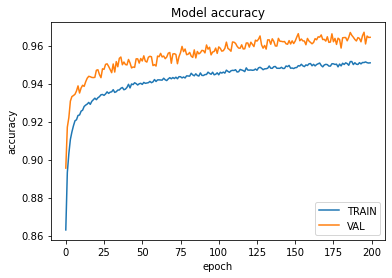

In [14]:
# Visualize the training history to see whether you're overfitting.
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['TRAIN', 'VAL'], loc='lower right')
plt.show()

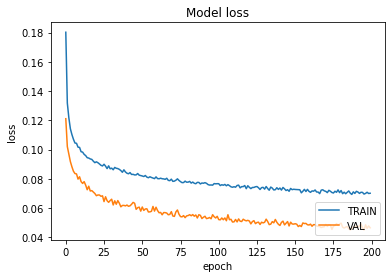

In [15]:
# Visualize the training history to see whether you're overfitting.
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['TRAIN', 'VAL'], loc='lower right')
plt.show()

In [16]:
loss, tp, fp, tn, fn, accuracy, precision, recall, auc, prc = model.evaluate(X_test, y_test)

125/125 [==============================] - 2s 2ms/step - loss: 0.0873 - tp: 2632.0000 - fp: 165.0000 - tn: 19835.0000 - fn: 1368.0000 - accuracy: 0.9361 - precision: 0.9410 - recall: 0.6580 - auc: 0.9788 - prc: 0.9161


Normalized confusion matrix

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.71      0.82       466
           1       0.85      0.72      0.78       805
           2       0.79      0.89      0.84       765
           3       0.77      0.80      0.78       719
           4       0.85      0.92      0.88       761
           5       0.90      0.99      0.94       484

    accuracy                           0.84      4000
   macro avg       0.85      0.84      0.84      4000
weighted avg       0.84      0.84      0.84      4000



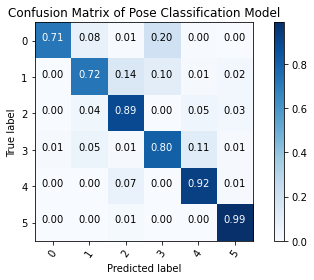

In [17]:
# Classify pose in the TEST dataset using the trained model
y_pred = model.predict(X_test)

# Convert the prediction result to class name
y_pred_label = [class_names[i] for i in np.argmax(y_pred, axis=1)]
y_true_label = [class_names[i] for i in np.argmax(y_test, axis=1)]

# Plot the confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))
plot_confusion_matrix(cm,
                      class_names,normalize=True,
                      title ='Confusion Matrix of Pose Classification Model')

# Print the classification report
print('\nClassification Report:\n', classification_report(y_true_label,
                                                          y_pred_label))

In [18]:
#Classes 3, 4 Need to be weighted

